In [11]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt


In [2]:
dataset_path = '/scratch/fk'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim  = 784

#TODO: Try with 10, 64, 128, 512 what do you observe?
hidden_dim = 128

#TODO: Try with 10, 20, 100 what do you observe?
latent_dim = 10

lr = 1e-3

# TODO: Try 100 if possible, and keep it fixed. If it takes time, then keep it 40
epochs = 30

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 5} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /scratch/fk/MNIST/raw/train-images-idx3-ubyte.gz to /scratch/fk/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /scratch/fk/MNIST/raw/train-labels-idx1-ubyte.gz to /scratch/fk/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /scratch/fk/MNIST/raw/t10k-images-idx3-ubyte.gz to /scratch/fk/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /scratch/fk/MNIST/raw/t10k-labels-idx1-ubyte.gz to /scratch/fk/MNIST/raw



In [4]:
# In the following, we will use conv2D, since it is an image, it should be better.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)     # TODO: call exactly same Conv2d as above.
        self.activation = nn.LeakyReLU(0.2)  # TODO: call leaky RELU with 0.2 parameter
        
    def forward(self, x):
        identity = x
        out = self.activation(self.conv1(x))
        out = self.conv2(out)
        out += identity # TODO: add identity to out
        return self.activation(out)

class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, latent_dim):
        super(Encoder, self).__init__()
        
        # Adjust the initial convolution block for 2D input
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=2, padding=1),  # Downsample to 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=2, padding=1),  # Downsample to 7x7
            nn.LeakyReLU(0.2)
        )
        
        # Residual blocks (remain the same, but with Conv2d)
        self.res_blocks = nn.Sequential(
            ResidualBlock(hidden_channels*2),
            ResidualBlock(hidden_channels*2)
        )
        
        # Use AdaptiveAvgPool2d to reduce spatial dimensions to 1x1 before FC layers
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adjust the FC layers input features after pooling
        self.FC_mean = nn.Linear(hidden_channels*2, latent_dim)  # Note the change in channels
        self.FC_var = nn.Linear(hidden_channels*2, latent_dim)
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.res_blocks(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # Flatten the features except for the batch dimension
        mean = self.FC_mean(x)
        log_var = self.FC_var(x)
        
        return mean, log_var


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualTransposeBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualTransposeBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(channels, channels, kernel_size=3, padding=1)   # call same ConvTranspose2d as above
        self.activation =  nn.LeakyReLU(0.2) # Call leaky RELU aith parameter 0.2
        
    def forward(self, x):
        identity = x
        out = self.activation(self.conv1(x))
        out = self.conv2(out)
        out += identity  # Element-wise addition, ensure dimensions match
        return self.activation(out)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_channels, output_channels):
        super(Decoder, self).__init__()
        
        # Example starting from a smaller spatial size
        self.fc = nn.Linear(latent_dim, hidden_channels * 7 * 7)
        
        # Upsampling layers
        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # to 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # to 28x28
            nn.Sigmoid()  # Assuming you're normalizing your images to [0, 1]
        )
        self.hidden_channels = hidden_channels
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.hidden_channels, 7, 7)  # Adjust the shape to what the first ConvTranspose2d layer expects
        x = self.conv_transpose_layers(x)
        return x


In [15]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, Encoder, Decoder, device):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.device = device  # Device (CPU or CUDA)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(self.device)  # Ensure epsilon is on the same device
        z = mean + var * epsilon  # Reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # log_var to var conversion
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var


In [16]:
input_channels = 1  # Assuming a single-channel input (e.g., grayscale image or single-feature time series)
hidden_channels = 64  # Channels in hidden convolutional layers
latent_dim = 128  # Size of the latent vector
output_channels = 1  # For reconstructing single-channel data
output_size = x_dim  # Assuming 'x_dim' is the length of the 1D data

encoder = Encoder(input_channels=input_channels, hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_channels=hidden_channels, output_channels=output_channels)
model = Model(encoder, decoder, DEVICE).to(DEVICE)


In [17]:
from torch.optim import Adam

def loss_function(x, x_hat, mean, log_var, binary=True):
    if binary:
        # Binary Cross-Entropy Loss for binary data
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')  # TODO: call nn.functional.binary_cross_entropy loss for x_hat and x with reduction='sum'
    else:
        # Mean Squared Error Loss for continuous data
        reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')  # TODO: call nn.functional.mse_loss to calculate loss between x_hat and x with reduction='sum')
    
    # Kullback-Leibler Divergence
    # Below a damp parameter is used. In some papers it was reported that keeping KL loss initially 
    damp = 1
    KLD = damp*(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))
    
    return KLD + reproduction_loss   # TODO return sum of reproduction_loss and KLD calculated above
    
optimizer = Adam(model.parameters(), lr=lr)

In [18]:
print("Start training VAE...")
epochs = 50

num_samples = len(train_loader.dataset)  # Total number of samples in the dataset

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # No need to reshape x for Conv2D, it should already be in the format [batch_size, channels, height, width]
        x = x.to(DEVICE)  # Ensure x is on the right device

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)  # Forward pass
        loss = loss_function(x, x_hat, mean, log_var, binary=False)  # Compute loss # TODO: try with both types of loss and show comparisons 

        overall_loss += loss.item() * x.size(0)  # Aggregate loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

    average_loss = overall_loss / num_samples  # Compute average loss
    print(f"\tEpoch {epoch + 1} complete! Average Loss: {average_loss:.4f}")


Start training VAE...
	Epoch 1 complete! Average Loss: 5418.9880
	Epoch 2 complete! Average Loss: 3921.5675
	Epoch 3 complete! Average Loss: 3477.6769
	Epoch 4 complete! Average Loss: 3297.8606
	Epoch 5 complete! Average Loss: 3208.7986
	Epoch 6 complete! Average Loss: 3152.4883
	Epoch 7 complete! Average Loss: 3110.4437
	Epoch 8 complete! Average Loss: 3075.1585
	Epoch 9 complete! Average Loss: 3043.3928
	Epoch 10 complete! Average Loss: 3018.3832
	Epoch 11 complete! Average Loss: 2998.5111
	Epoch 12 complete! Average Loss: 2980.9292
	Epoch 13 complete! Average Loss: 2960.3033
	Epoch 14 complete! Average Loss: 2947.4973
	Epoch 15 complete! Average Loss: 2931.0817
	Epoch 16 complete! Average Loss: 2919.4501
	Epoch 17 complete! Average Loss: 2909.8075
	Epoch 18 complete! Average Loss: 2900.0100
	Epoch 19 complete! Average Loss: 2890.9248
	Epoch 20 complete! Average Loss: 2886.7619
	Epoch 21 complete! Average Loss: 2875.8159
	Epoch 22 complete! Average Loss: 2873.4449
	Epoch 23 complete!

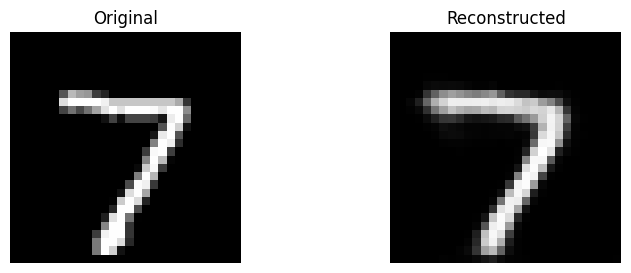

In [19]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        # No need to reshape x for Conv2D, it should already be in the format [batch_size, 1, 28, 28]
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        # Proceed with any further processing or visualization
        # For example, you might want to visualize the first image and its reconstruction
        # This is just a simple example assuming your tensors are on a GPU and need to be moved to CPU
        if batch_idx == 0:  # Just an example to visualize the first batch
            import matplotlib.pyplot as plt
            
            original_img = x[0].cpu().squeeze().numpy()
            reconstructed_img = x_hat[0].cpu().squeeze().numpy()
            
            plt.figure(figsize=(9, 3))
            
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(original_img, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title("Reconstructed")
            plt.imshow(reconstructed_img, cmap='gray')
            plt.axis('off')
            
            plt.show()
            
        break  # This will exit the loop after the first batch; remove if processing the entire dataset


In [20]:
# use this to display one image, can be useful for latent space interpolations
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [21]:
# use this to show grid of images
import matplotlib.pyplot as plt

def show_image_grid(x):
    # Reshape if necessary, assuming x has shape [batch_size, height, width]
    if x.dim() == 4 and x.size(1) == 1:  # In case x has shape [batch_size, 1, height, width]
        x = x.squeeze(1)  # Remove channel dimension for grayscale images
        
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(4, 4))
    for i in range(25):  # Display the first 25 images
        ax = axs[i // 5, i % 5]
        ax.imshow(x[i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


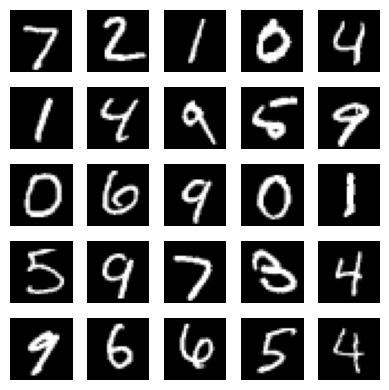

In [22]:
show_image_grid(x)

In [23]:
#show_image(x, idx=1)

In [24]:
#show_image(x_hat, idx=0)

In [25]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [26]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

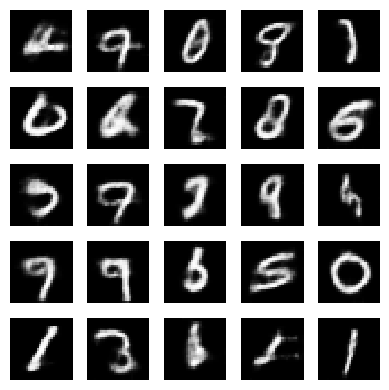

In [82]:
# Generate ten 5 x 5 grid of generated images, and upload notebook and images as zip file.
import matplotlib.pyplot as plt
import numpy as np

def show_image_grid(images, rows=5, cols=5, figsize=(4, 4)):
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            # Assuming images are in PyTorch tensor format; convert them to numpy
            img = images[i].cpu().detach()
            if img.dim() == 3 and img.size(0) == 3:  # If it's a 3-channel image
                img = img.permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
            elif img.dim() == 3:  # If it's a single channel image
                img = img.squeeze(0)  # Remove channel dimension
            ax.imshow(img, cmap='gray', interpolation='none')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming generated_images is a tensor of shape [25, 1, 28, 28] or [25, 28, 28]
# Adjust the tensor shape according to your data format
show_image_grid(generated_images, 5, 5)


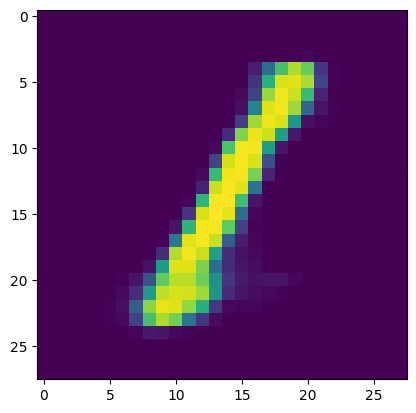

In [85]:
show_image(generated_images, idx=20)

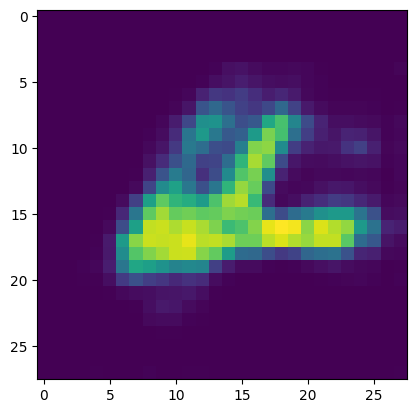

In [86]:
show_image(generated_images, idx=0)

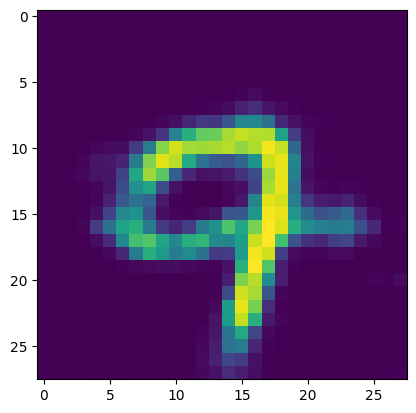

In [88]:
show_image(generated_images, idx=1)

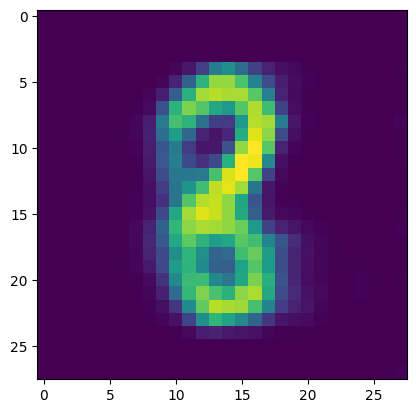

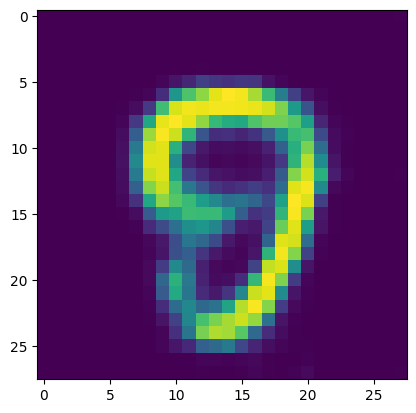

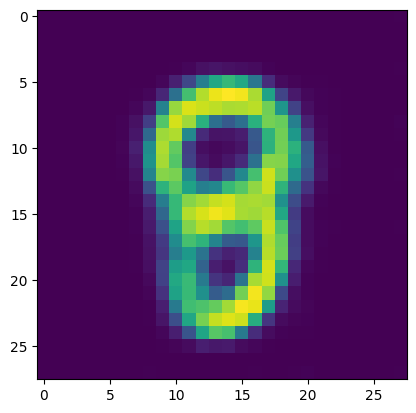

In [89]:
# Latent space interpolation
batch_size = 1 # keep it one
with torch.no_grad():
    noise1 = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_image1 = decoder(noise1)

show_image(generated_image1, idx=0)

batch_size = 1 # keep it one
with torch.no_grad():
    noise2 = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_image2 = decoder(noise2)

show_image(generated_image2, idx=0)

# do latent space interpolation
with torch.no_grad():
    noise3 = 0.5 * noise1 + 0.5 * noise2
    generated_image3 = decoder(noise3)

show_image(generated_image3, idx=0)

In [41]:
# In this cell we will plot the generated images, we first sample a noise vector, then pass it through decoder. 
# We also play with latent space interpolations. 
# As you can see, "continuous latent space interpolations usually does not mean anything", this was the motivation for discrete 
# latents as proposed in VQ-VAE paper: https://arxiv.org/abs/1711.00937
# Not just that we see that discrete latents can be very useful of maintaining ordering of latents for audio, video data!
# TODO: If possible, try FMNIST, or even more CIFAR10 dataset, which is a color dataset! You need to change the channels and 
# height and width dimensions in this case. 

import matplotlib.pyplot as plt

def show_images_side_by_side(images):
    """
    Display images side by side in a single row.
    Parameters:
    - images: List of image tensors, each of shape [1, height, width].
    """
    fig, axs = plt.subplots(1, len(images), figsize=(3, 1))
    for idx, img in enumerate(images):
        img = img.squeeze()  # Remove batch dimension and channel dimension if present
        axs[idx].imshow(img.cpu().numpy(), cmap='gray')
        axs[idx].axis('off')
    plt.show()

# Assuming decoder is defined and DEVICE is set
# Generate images
def interpolate(alpha):
    with torch.no_grad():
        noise1 = torch.randn(batch_size, latent_dim).to(DEVICE)
        generated_image1 = decoder(noise1).view(batch_size, 28, 28)  # Ensure it's reshaped to [batch_size, height, width]

        noise2 = torch.randn(batch_size, latent_dim).to(DEVICE)
        generated_image2 = decoder(noise2).view(batch_size, 28, 28)

        # Latent space interpolation: interpolate between two noise vectors: noise1 and noise2 to generate something "in-between"
        # alpha = 0.6
        # write a new noise vector noise3 as a convex combination of noise1 and noise2
        # note that convex combination of two vectors u and v is: w = alpha * u + (1 - alpha)*v
        noise3 = alpha * noise1 + (1-alpha) * noise2
        generated_image3 = decoder(noise3).view(batch_size, 28, 28)

        # Show images side by side
        for i in range(4):
            show_images_side_by_side([generated_image1[i], generated_image2[i], generated_image3[i]])


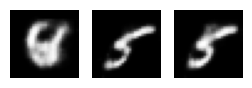

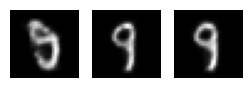

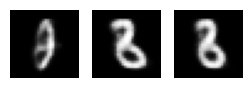

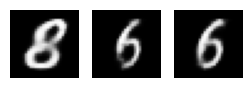

In [42]:
interpolate(0.2)


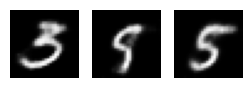

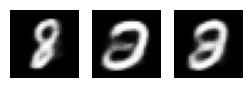

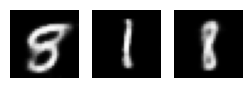

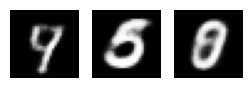

In [80]:
interpolate(0.4)

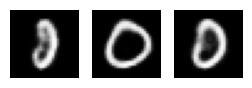

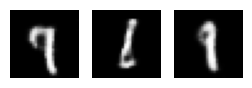

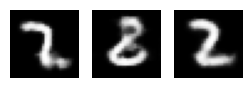

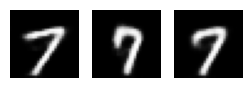

In [44]:
interpolate(0.6)

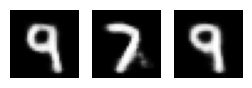

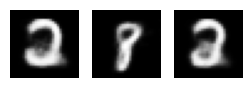

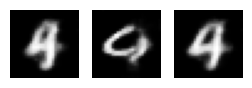

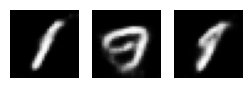

In [45]:
interpolate(0.8)

##### Observations

1. Extremely small values generated images similar to the 2nd image while extremely large values generated images similar to the 1st image.
2. However, with alpha=0.4 we got some nice interpolations between the 1st and 2nd image.